<a href="https://colab.research.google.com/github/mfmceneaney/DIRC_COLAB/blob/Iterations-for-Stability/Copy_of_DIRC_CNN_HISTORY_STABILITY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Using GPU speeds up CNN training
# Go to Edit > Notebook Settings > Hardware Accelerator and select GPU

In [2]:
print(" > Installing uproot...")
!pip install uproot

 > Installing uproot...
     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 92kB 10.4MB/s 


In [3]:
import uproot

# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
import math

from __future__ import absolute_import, division, print_function, unicode_literals


try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, metrics

# Added installation to fix the following warning message when fitting CNN
# You will have to run this cell twice and restart the runtime
# WARNING:tensorflow:Entity <function Function._initialize_uninitialized_variables..initialize_variables at 0x7fd89803cef0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, export AUTOGRAPH_VERBOSITY=10) and attach the full output. Cause: module 'gast' has no attribute 'Num'

!pip install gast==0.2.2

TensorFlow 2.x selected.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# initialize images
image_kplus = np.zeros(shape=(48,144))
image_piplus = np.zeros(shape=(48,144))
images_kplus = []
images_piplus = []
images_flat_kplus = []
images_flat_piplus = []

#h2_kplus = ROOT.TH2F("kplus","Hit Pattern K+; PixelRow; PixelCol",144,-0.5,143.5,48,-0.5,47.5)
#h2_piplus = ROOT.TH2F("piplus","Hit Pattern pi+; PixelRow; PixelCol",144,-0.5,143.5,48,-0.5,47.5)

# get data from files
print("Opening files")
piplus = uproot.open("/content/gdrive/My Drive/piplus_p3_theta4_flat.root")["dircml_flat"]
kplus = uproot.open("/content/gdrive/My Drive/kplus_p3_theta4_flat.root")["dircml_flat"]

# fill histogram with # photon hits
#plt.axis([0, 250, 0, 5000])
#plt.hist(NPixelsArr, 4000) #, 0, 100) #bins='auto')
#plt.title("Histogram with 'auto' bins")
#plt.show()

eventMax = 10000
eventCounter = 0

print("Filling image arrays")
# loop over kplus events
for (PixelTimes,PixelRows,PixelCols) in zip(kplus.array("PixelTime"),kplus.array("PixelRow"),kplus.array("PixelCol")):
    #print("event")
    image_single = np.zeros(shape=(48,144))
    
    # loop over pixels within event
    for (PixelTime,PixelRow,PixelCol) in zip(PixelTimes,PixelRows,PixelCols):
        #print("PixelTime,Row,Col = %f,%d,%d" % (PixelTime,PixelRow,PixelCol))
        image_kplus[PixelCol,PixelRow] += 1
        image_single[PixelCol,PixelRow] = PixelTime
        #h2_kplus.Fill(PixelRow,PixelCol)
    
    # after each event
    images_kplus.append(image_single)
    images_flat_kplus.append(np.reshape(image_single, 6912))
    
    eventCounter = eventCounter+1
    if eventCounter > eventMax:
        break

eventCounter = 0
        
# loop over piplus events
for (PixelTimes,PixelRows,PixelCols) in zip(piplus.array("PixelTime"),piplus.array("PixelRow"),piplus.array("PixelCol")):
    #print("event")
    image_single = np.zeros(shape=(48,144))
    
    # loop over pixels within event
    for (PixelTime,PixelRow,PixelCol) in zip(PixelTimes,PixelRows,PixelCols):
        #print("PixelTime,Row,Col = %f,%d,%d" % (PixelTime,PixelRow,PixelCol))
        image_piplus[PixelCol,PixelRow] += 1
        image_single[PixelCol,PixelRow] = PixelTime
        #h2_piplus.Fill(PixelRow,PixelCol)
    
    # after each event
    images_piplus.append(image_single)
    images_flat_piplus.append(np.reshape(image_single, 6912))
    
    eventCounter = eventCounter+1
    if eventCounter > eventMax:
        break

Opening files
Filling image arrays


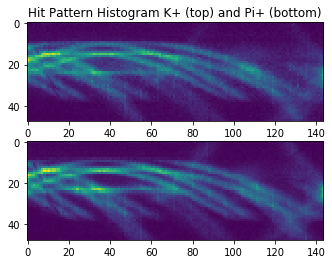

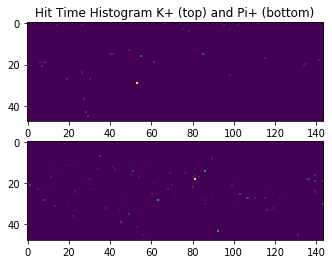

In [6]:
# draw cumulative image
plt.axis([-0.5, 143.5, -0.5, 47.5])
plt.subplot(2, 1, 1)
plt.title("Hit Pattern Histogram K+ (top) and Pi+ (bottom)")
plt.imshow(image_kplus, cmap='viridis')
plt.subplot(2, 1, 2)
plt.title("")
plt.imshow(image_piplus, cmap='viridis')
plt.show()

# draw single event image
plt.subplot(2, 1, 1)
plt.title("Hit Time Histogram K+ (top) and Pi+ (bottom)")
plt.imshow(images_kplus[0], cmap='viridis')
plt.subplot(2, 1, 2)
plt.title("")
plt.imshow(images_piplus[0], cmap='viridis')
#plt.show()

# draw ROOT image
#can = ROOT.TCanvas("cc","cc",600,500)
#can.Divide(1,2)
#can.cd(1)
#h2_kplus.Draw("colz")
#can.cd(2)
#h2_piplus.Draw("colz")
#can.Print("HitPattern.png")

In [7]:
# Split samples into training and testing
print("Splitting sample into training and testing subsets")
split = 2
n_kplus = len(images_kplus)
n_piplus = len(images_piplus)
n_total = n_kplus + n_piplus

images_train_kplus = images_kplus[:n_kplus // split]
images_train_piplus = images_piplus[:n_piplus // split]
n_train_kplus = len(images_train_kplus)
n_train_piplus = len(images_train_piplus)
n_train_total = n_train_kplus + n_train_piplus

images_test_kplus = images_kplus[n_kplus // split:]
images_test_piplus = images_piplus[n_piplus // split:]
n_test_kplus = len(images_test_kplus)
n_test_piplus = len(images_test_piplus)
n_test_total = n_test_kplus + n_test_piplus

data_train = np.concatenate((images_train_kplus, images_train_piplus))
data_test = np.concatenate((images_test_kplus, images_test_piplus))
data = np.concatenate((images_kplus, images_piplus))

target_train = np.concatenate((np.ones(n_train_kplus), np.zeros(n_train_piplus)))
target_test = np.concatenate((np.ones(n_test_kplus), np.zeros(n_test_piplus)))
target = np.concatenate((np.ones(n_kplus), np.zeros(n_piplus)))


print(data_train.shape)
print(data.shape)
print(target.shape)
print(np.unique(target))

print("Training size = %d" % len(data_train))
print("Testing size = %d" % len(data_test))
"""
print(images_kplus[1].shape)
print(images_piplus[0].shape)

print(data.max())
print(data_train.max())
print(data_test.max())
print(data.min())
print(data_train.min())
print(data_test.min())
"""

Splitting sample into training and testing subsets
(10000, 48, 144)
(20002, 48, 144)
(20002,)
[0. 1.]
Training size = 10000
Testing size = 10002


'\nprint(images_kplus[1].shape)\nprint(images_piplus[0].shape)\n\nprint(data.max())\nprint(data_train.max())\nprint(data_test.max())\nprint(data.min())\nprint(data_train.min())\nprint(data_test.min())\n'

In [8]:
# Reshape Data (?) 
data_train_images = data_train.reshape(len(data_train), 48, 144, 1)
target_train_images = target_train.reshape(len(target_train))

data_test_images = data_test.reshape(len(data_test), 48, 144, 1)
target_test_images = target_test.reshape(len(target_test))

# Normalize pixel absolute values to be between 0 and 1
data_train_images = data_train_images / data.max()
data_test_images = data_test_images / data.max()

#print(data_train_images.max())
#print(data_test_images.max())

print("Data shape: "+str(data_train_images.shape))
print("Target shape: "+str(target_train_images.shape))

Data shape: (10000, 48, 144, 1)
Target shape: (10000,)


In [0]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')
  
  f = plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  plt.show()
  f.savefig("histories.png")
  
  # Convert accuracy and loss plots into ROOT histograms
  print("Converting plots to ROOT...")

  file = uproot.recreate("histories.root", compression=uproot.ZLIB(4))
  file["acc"] = np.histogram2d(metrics[0],metrics[1])
  
  # Download png and root files
  print("Downloading files...")

  from google.colab import files
  files.download("histories.png")
  files.download("histories.root")

In [0]:
#################################### Stability (changing all layers) ########################################
import time
start_time = time.time()
metrics = [ [], [], [],  [ [], [], [] ],  [ [], [], [] ]  ]
minimum = 1
maximum = 16
step = 1
iterations = 101
for n in range(minimum,maximum,step):
  print("Creating model "+str((n - minimum + 1))+"...")
  
  # CNN takes 3 dimensional tensor input (image height, image width, color channel) 
  model = models.Sequential()
  # Padding='same' significantly improves results
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', input_shape=(48, 144, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(2*n, (3, 3), strides=(1,1), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(2*n, (3, 3), strides=(1,1), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(2*n, activation='relu'))
  # Final layer must have two outputs since we are distinguishing between only two particles
  model.add(layers.Dense(2, activation='softmax'))

  # Print CNN Architecture
  #model.summary()

  # Train CNN
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'], verbose=0)
  
  metrics = [ [], [], [],  [ [], [], [] ],  [ [], [], [] ]  ]
  
  for iteration in range(iterations):
    
    model.fit(data_train_images, target_train_images, epochs=10, verbose=0, batch_size=n, validation_data=(data_test_images,target_test_images), steps_per_epoch=15) #
  
    # Accuracy and Loss for CNN
    test_loss, test_acc = model.evaluate(data_test_images, target_test_images, verbose=0)
    metrics[0].append((n+iteration)%10)
    metrics[1].append(test_acc)
    metrics[2].append(test_loss)
  
    ###################  Evaluation  #################

    # Evaluate performance by comparing test and training classifier (model) response
    decisions = []
    for (X,y) in ((data_train_images, target_train_images), (data_test_images, target_test_images)):
      d1 = model.predict_proba(X[y>0.5])[:,1].ravel()
      d2 = model.predict_proba(X[y<0.5])[:,1].ravel()
      decisions += [d1, d2]
  
    ################  Find Purity and Chi2  ################  
  
    # set histogram parameters
    bins = 100
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)

    # make test and train decisions histograms for kaon
    hist_kaon_test, bins = np.histogram( decisions[0], bins=bins, range=low_high, density=False)
    hist_kaon_train, bins = np.histogram( decisions[2], bins=bins, range=low_high, density=False)
  
    # find chi2 values and error for kaon
    hist_kaon_chi2 = np.nan_to_num(np.divide(np.square(np.subtract(hist_kaon_test, hist_kaon_train)),np.add(hist_kaon_test,hist_kaon_train)))
    scale = len(decisions[2]) / sum(hist_kaon_chi2)
    err_kaon = np.sqrt(hist_kaon_chi2 * scale) / scale
  
    # make test and train decisions histograms for pion
    hist_pion_test, bins = np.histogram( decisions[1], bins=bins, range=low_high, density=False)
    hist_pion_train, bins = np.histogram( decisions[3], bins=bins, range=low_high, density=False)
  
    # find chi2 values and error for pion
    hist_pion_chi2 = np.nan_to_num(np.divide(np.square(np.subtract(hist_pion_test, hist_pion_train)),np.add(hist_pion_test,hist_pion_train)))
    scale = len(decisions[2]) / sum(hist_pion_chi2)
    err_pion = np.sqrt(hist_pion_chi2 * scale) / scale
  
    # find chi2 for kaon and pion and total
    chi2_kaon = sum(hist_kaon_chi2)
    chi2_pion = sum(hist_pion_chi2)
    chi2_total = chi2_kaon + chi2_pion
    err_total = math.sqrt(sum(err_kaon**2 + err_pion**2))
    metrics[3][0].append(chi2_kaon)
    metrics[3][1].append(chi2_pion)
    metrics[3][2].append(chi2_total)
    metrics[4][0].append(err_kaon)
    metrics[4][1].append(err_pion)
    metrics[4][2].append(err_total)
  
    print("t = "+str(round(time.time()-start_time))+"s")


  ################  Plot Purity and Chi2  ################
  print("Plotting purity and \u03C7\u00b2")

  # Plot accuracy
  f = plt.figure()
  plt.plot(metrics[0],metrics[1],'b.', scaley = False)
  plt.title("Accuracy, batch_size = "+str(n*32))
  plt.xlabel("Iteration, Layers = 32")
  plt.ylabel("Arbitrary units")
  plt.show()
  f.savefig("stability_acc"+str(n)+".png")

  # Plot loss
  f = plt.figure()
  plt.plot(metrics[0],metrics[2],'b.', scaley = False)
  plt.title("Loss, batch_size = "+str(n*32))
  plt.xlabel("Iteration, Layers = 32")
  plt.ylabel("Arbitrary units")
  plt.show()
  f.savefig("stability_loss"+str(n)+".png")

  # Plot kaon chi2
  f = plt.figure()
  plt.plot(metrics[0],metrics[3][0],'b.')
  plt.title("Kaon \u03C7\u00b2, batch_size = "+str(n*32))
  plt.xlabel("Iteration, Layers = 32")
  plt.ylabel("Arbitrary units")
  plt.show()
  f.savefig("stability_chi2_kaon"+str(n)+".png")

  # Plot pion chi2
  f = plt.figure()
  plt.plot(metrics[0],metrics[3][1],'b.')
  plt.title("Pion \u03C7\u00b2, batch_size = "+str(n*32))
  plt.xlabel("Iteration, Layers = 32")
  plt.ylabel("Arbitrary units")
  plt.show()
  f.savefig("stability_chi2_pion"+str(n)+".png")

  # Plot total chi2
  f = plt.figure()
  plt.plot(metrics[0],metrics[3][2],'b.')
  plt.title("Total \u03C7\u00b2, batch_size = "+str(n*32))
  plt.xlabel("Iteration, Layers = 32")
  plt.ylabel("Arbitrary units")
  plt.show()
  f.savefig("stability_chi2_tot"+str(n)+".png")
  
"""  # Convert accuracy and loss plots into ROOT histograms
  print("Converting plots to ROOT...")

  file = uproot.recreate("stability_acc.root", compression=uproot.ZLIB(4))
  file["acc"] = np.histogram2d(metrics[0],metrics[1])

  file = uproot.recreate("stability_loss.root", compression=uproot.ZLIB(4))
  file["loss"] = np.histogram2d(metrics[0],metrics[2])

  file = uproot.recreate("stability_chi2_kaon.root", compression=uproot.ZLIB(4))
  file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])
  
  file = uproot.recreate("stability_chi2_pion.root", compression=uproot.ZLIB(4))
  file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

  file = uproot.recreate("stability_chi2_tot.root", compression=uproot.ZLIB(4))
  file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])
  """
  # Download png and root files
  print("Downloading files...")

  from google.colab import files
  files.download("stability_acc"+str(n)+".png")
  files.download("stability_loss"+str(n)+".png")
  files.download("stability_chi2_kaon"+str(n)+".png")
  files.download("stability_chi2_pion"+str(n)+".png")
  files.download("stability_chi2_tot"+str(n)+".png")
  """
  files.download("stability_acc.root")
  files.download("stability_loss.root")
  files.download("stability_chi2_kaon.root")
  files.download("stability_chi2_pion.root")
  files.download("stability_chi2_tot.root")
  """
print("t = "+str(round(time.time()-start_time))+"s")


################################################################################################


Creating model 1...


ResourceExhaustedError: ignored

In [0]:
# Training times callback class definition
import time
class training_times(tf.keras.callbacks.Callback):
    def __init__(self,n):
        self.times = []
        self.t0 = 0
        
    def get_times(self):
        return self.times
      
    def on_epoch_begin(self,epoch,logs = {}):
        self.t0 = time.clock()
        
    def on_epoch_end(self,epoch,logs = {}):
        t=time.clock()
        self.times.append((epoch,(t - self.t0)/10))
        
"""
    def on_train_end(self,logs = {}):
        f = plt.figure(figsize=(16,10))
        plt.xlabel('Epoch')
        plt.ylabel('Time per epoch (s)')
        plt.plot(*zip(*self.times))
        plt.show()
        f.savefig("epochs_times"+str(n)+".png")
        file = uproot.recreate("epochs_times"+str(n)+".root", compression=uproot.ZLIB(4))
        file["times"] = np.histogram2d(*zip(*self.times))
"""

'\n    def on_train_end(self,logs = {}):\n        f = plt.figure(figsize=(16,10))\n        plt.xlabel(\'Epoch\')\n        plt.ylabel(\'Time per epoch (s)\')\n        plt.plot(*zip(*self.times))\n        plt.show()\n        f.savefig("epochs_times"+str(n)+".png")\n        file = uproot.recreate("epochs_times"+str(n)+".root", compression=uproot.ZLIB(4))\n        file["times"] = np.histogram2d(*zip(*self.times))\n'

In [0]:
class CategoricalTruePositives(tf.keras.metrics.Metric):

    def __init__(self, name='categorical_true_positives', **kwargs):
      super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
      self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
      y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1,1))
      values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
      values = tf.cast(values, 'float32')
      if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, 'float32')
        values = tf.multiply(values, sample_weight)
      self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
      return self.true_positives

    def reset_states(self):
      # The state of the metric will be reset at the start of each epoch.
      self.true_positives.assign(0.)


In [0]:
class chi2(tf.keras.metrics.Metric):

    def __init__(self, name='chi2', **kwargs):
      super(mse, self).__init__(name=name, **kwargs)
      self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
      y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1,1))
      values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
      values = tf.cast(values, 'float32')
      if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, 'float32')
        values = tf.multiply(values, sample_weight)
      self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
      return self.true_positives

    def reset_states(self):
      # The state of the metric will be reset at the start of each epoch.
      self.true_positives.assign(0.)



In [0]:
# Increase Learning Rate Callback class definition
from tensorflow.python.keras import backend as K
class IncreaseLROnPlateau(tf.keras.callbacks.ReduceLROnPlateau):
  """Modified by Matthew McEneaney 10/30/19 copied from TensorFlow API Python Documentation for the ReduceLROnPlateau Callback at
  https://github.com/tensorflow/tensorflow/blob/r2.0/tensorflow/python/keras/callbacks.py#L1765-L1795
  """
  """Reduce learning rate when a metric has stopped improving.
  Models often benefit from reducing the learning rate by a factor
  of 2-10 once learning stagnates. This callback monitors a
  quantity and if no improvement is seen for a 'patience' number
  of epochs, the learning rate is reduced.
  Example:
  ```python
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.001)
  model.fit(X_train, Y_train, callbacks=[reduce_lr])
  ```
  Arguments:
      monitor: quantity to be monitored.
      factor: factor by which the learning rate will be reduced. new_lr = lr *
        factor
      patience: number of epochs with no improvement after which learning rate
        will be reduced.
      verbose: int. 0: quiet, 1: update messages.
      mode: one of {auto, min, max}. In `min` mode, lr will be reduced when the
        quantity monitored has stopped decreasing; in `max` mode it will be
        reduced when the quantity monitored has stopped increasing; in `auto`
        mode, the direction is automatically inferred from the name of the
        monitored quantity.
      min_delta: threshold for measuring the new optimum, to only focus on
        significant changes.
      cooldown: number of epochs to wait before resuming normal operation after
        lr has been reduced.
      min_lr: lower bound on the learning rate.
  """
  def __init__(self,
               monitor='val_loss',
               factor=1.1,
               patience=10,
               verbose=0,
               mode='auto',
               min_delta=1e-4,
               cooldown=0,
               min_lr=0,
               **kwargs):
    super(tf.keras.callbacks.ReduceLROnPlateau, self).__init__()
    self.monitor = monitor
    if factor <= 1.0:
      raise ValueError('IncreaseLROnPlateau ' 'does not support a factor N= 1.0.')
    if 'epsilon' in kwargs:
      min_delta = kwargs.pop('epsilon')
      logging.warning('`epsilon` argument is deprecated and '
                      'will be removed, use `min_delta` instead.')
    self.factor = factor
    self.min_lr = min_lr
    self.min_delta = min_delta
    self.patience = patience
    self.verbose = verbose
    self.cooldown = cooldown
    self.cooldown_counter = 0  # Cooldown counter.
    self.wait = 0
    self.best = 0
    self.mode = mode
    self.monitor_op = None
    self._reset()

  def _reset(self):
    """Resets wait counter and cooldown counter.
    """
    if self.mode not in ['auto', 'min', 'max']:
      logging.warning('Learning Rate Plateau Reducing mode %s is unknown, '
                      'fallback to auto mode.', self.mode)
      self.mode = 'auto'
    if (self.mode == 'min' or
        (self.mode == 'auto' and 'acc' not in self.monitor)):
      self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
      self.best = np.Inf
    else:
      self.monitor_op = lambda a, b: np.greater(a, b + self.min_delta)
      self.best = -np.Inf
    self.cooldown_counter = 0
    self.wait = 0

  def on_train_begin(self, logs=None):
    self._reset()

  def on_epoch_end(self, epoch, logs=None):
    logs = logs or {}
    logs['lr'] = K.get_value(self.model.optimizer.lr)
    current = logs.get(self.monitor)
    if current is None:
      logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                      'which is not available. Available metrics are: %s',
                      self.monitor, ','.join(list(logs.keys())))

    else:
      if self.in_cooldown():
        self.cooldown_counter -= 1
        self.wait = 0

      if self.monitor_op(current, self.best):
        self.best = current
        self.wait = 0
      elif not self.in_cooldown():
        self.wait += 1
        if self.wait >= self.patience:
          old_lr = float(K.get_value(self.model.optimizer.lr))
          if old_lr > self.min_lr:
            new_lr = old_lr * self.factor
            new_lr = max(new_lr, self.min_lr)
            K.set_value(self.model.optimizer.lr, new_lr)
            if self.verbose > 0:
              print('\nEpoch %05d: ReduceLROnPlateau reducing learning '
                    'rate to %s.' % (epoch + 1, new_lr))
            self.cooldown_counter = self.cooldown
            self.wait = 0

  def in_cooldown(self):
    return self.cooldown_counter > 0


Creating model 1...
Compiling...
Fitting...
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse', 'lr'])


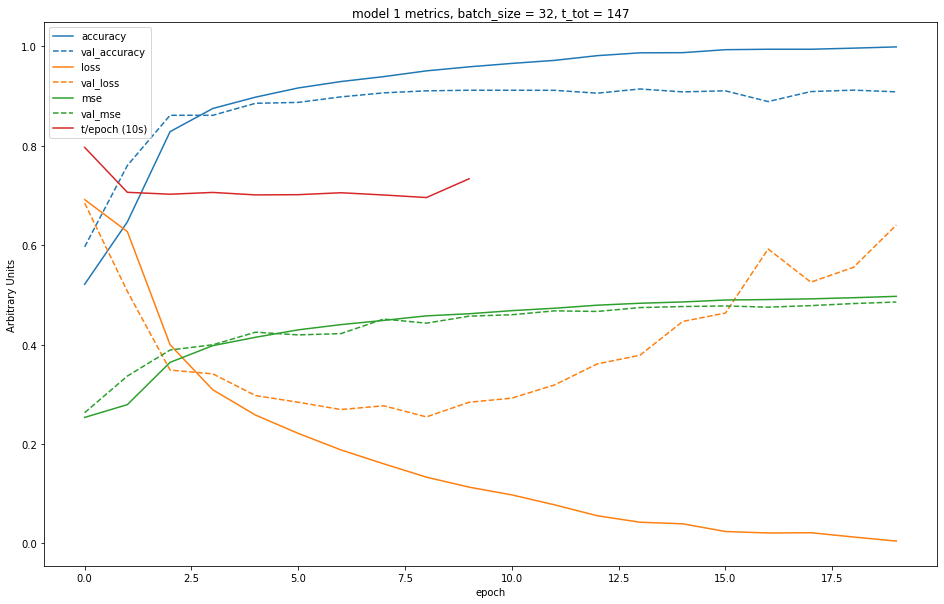

Creating model 2...
Compiling...
Fitting...
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse', 'lr'])


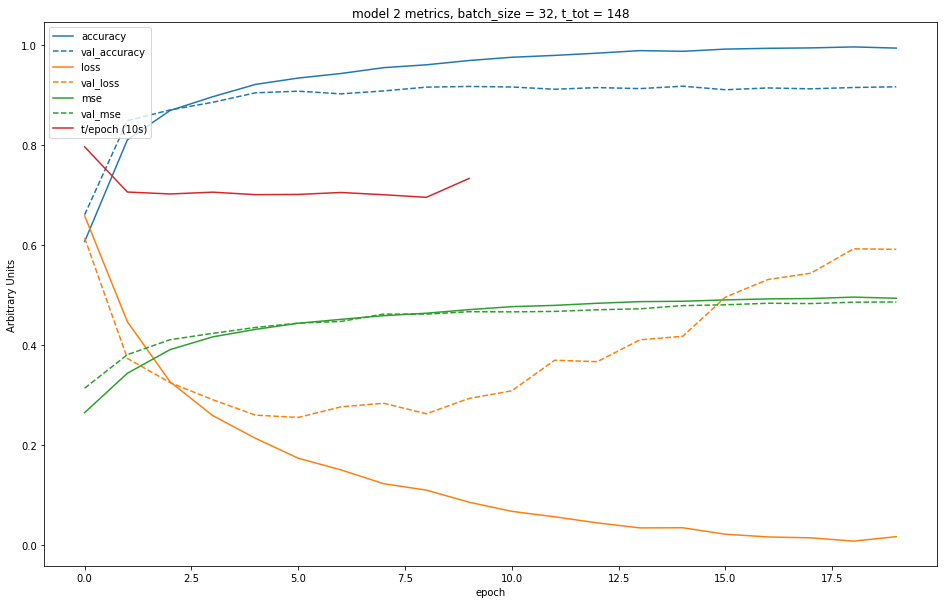

Creating model 3...
Compiling...
Fitting...
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse', 'lr'])


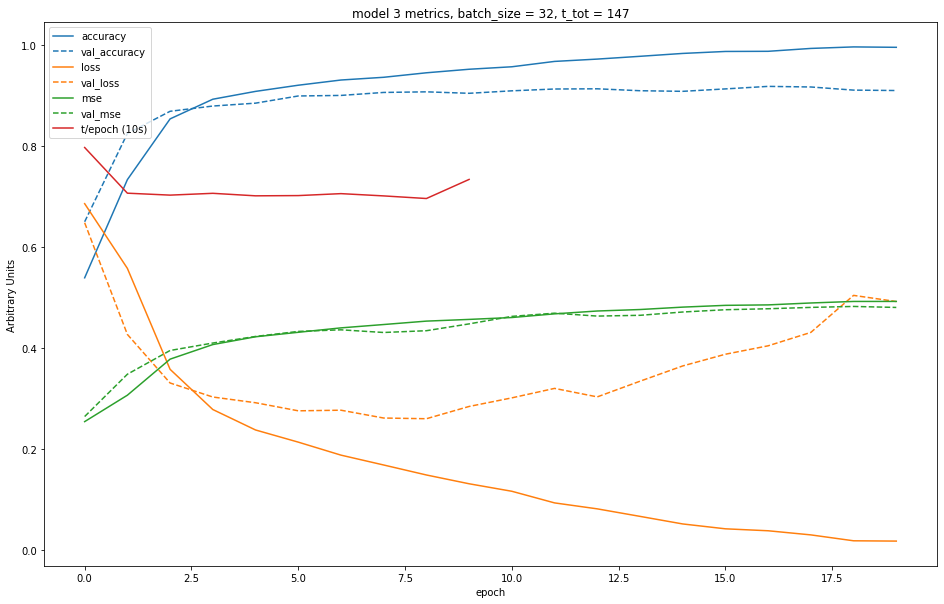

Creating model 4...
Compiling...
Fitting...
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse', 'lr'])


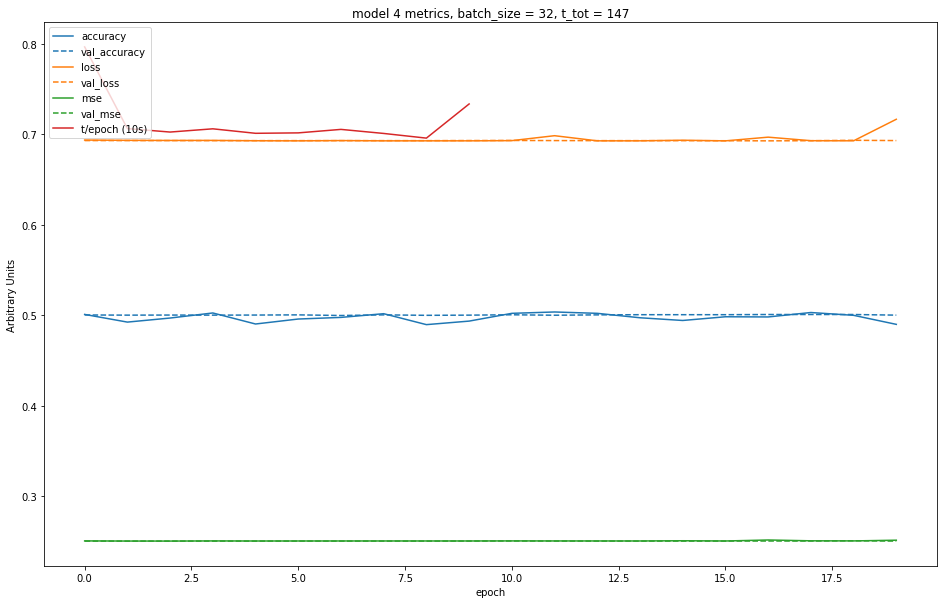

Creating model 5...
Compiling...
Fitting...
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse', 'lr'])


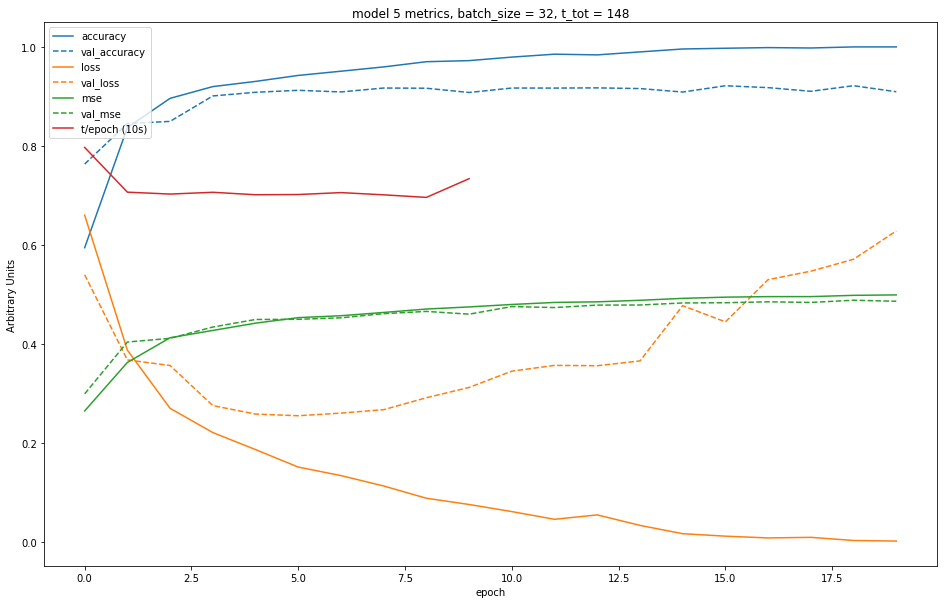

Creating model 6...
Compiling...
Fitting...
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse', 'lr'])


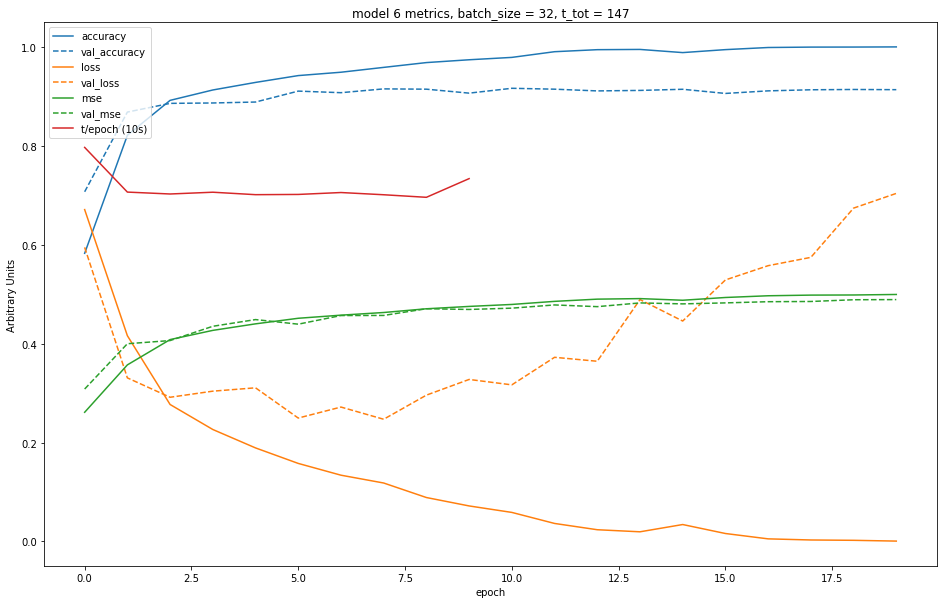

Creating model 7...
Compiling...
Fitting...
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse', 'lr'])


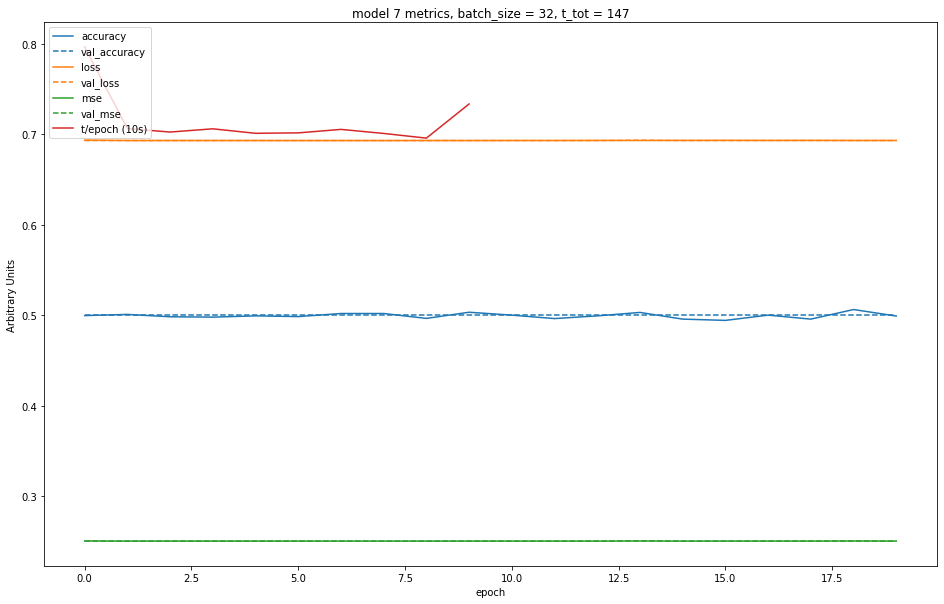

Creating model 8...
Compiling...
Fitting...
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse', 'lr'])


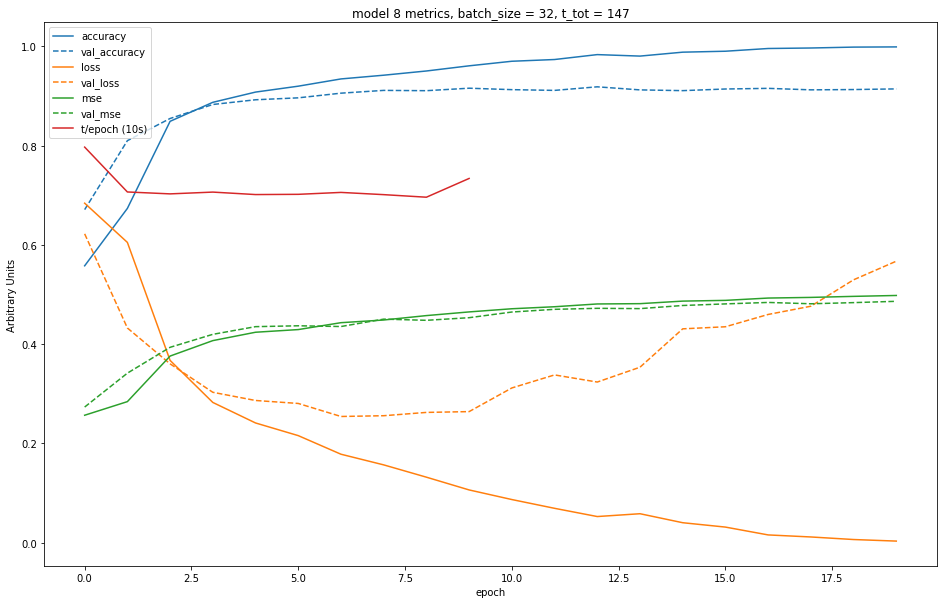

Creating model 9...
Compiling...
Fitting...
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse', 'lr'])


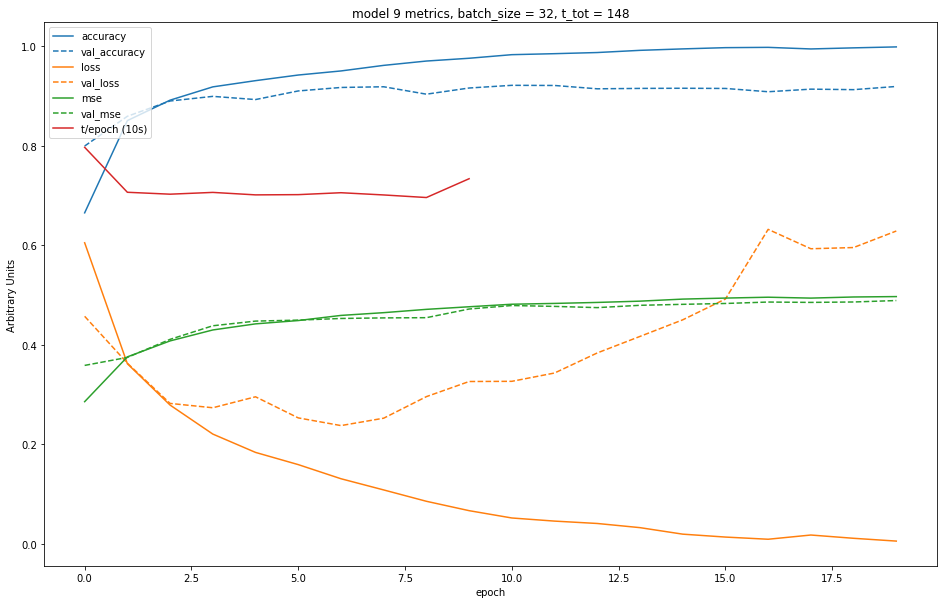

Creating model 10...
Compiling...
Fitting...
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse', 'lr'])


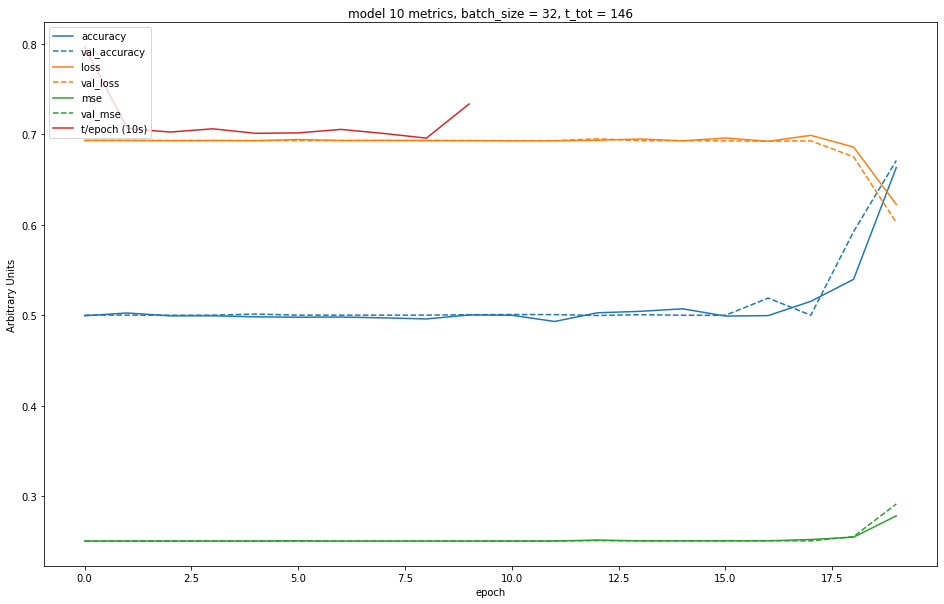

In [0]:
import math, time

#################################### Histories ########################################
#metrics = [ [], [], [],  [ [], [], [] ],  [ [], [], [] ]  ]
histories = []
minimum = 1
maximum = 11
step = 1
numEpochs = 20
size = 32 #batch_size: number of samples before each gradient step, default batch_size=32
ep = []
times = []
for i in range(1,numEpochs+1,1):
  ep.append(i)
  
for n in range(minimum,maximum,step):
  print("Creating model "+str((n - minimum + 1))+"...")
  
  # CNN takes 3 dimensional tensor input (image height, image width, color channel) 
  model = models.Sequential()
  # Padding='same' significantly improves results
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', input_shape=(48, 144, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  # Final layer must have two outputs since we are distinguishing between only two particles
  model.add(layers.Dense(2, activation='softmax'))

  # Print CNN Architecture
  #model.summary()

  # Train CNN
  print("Compiling...")
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy','mse'], verbose=0) #,tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives()
  
  print("Fitting...")
  # This callback will stop the training when there is no improvement in
  # the validation loss for three consecutive epochs.
  #callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
  time_epochs = training_times(numEpochs)
  # Added 10/30/19
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.001)
  increase_lr = IncreaseLROnPlateau(monitor='loss', factor=3, patience=10, min_lr=0.001)
  # This function keeps the learning rate at 0.001 for the first ten epochs
  # and decreases it exponentially after that.
  """def scheduler(epoch):
    if epoch < 10:
      return 0.001
    else:
      return 0.001 * tf.math.exp(0.1 * (10 - epoch))

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)"""
  
  val_split = 0.1
  t = time.time()
  history = model.fit(data_train_images, target_train_images, batch_size=size, epochs=numEpochs, callbacks=[time_epochs, increase_lr], verbose=0, validation_data=(data_test_images, target_test_images)) # 
  t = time.time() - t
  times.append(t)
  
  # Add the fit to histories so it is available to look at more closely afterward
  histories.append(history)
  

  #print("Time elapsed: "+str(t))
  
  # Evaluate CNN
  results = model.evaluate(data_test_images,
                           target_test_images,
                           verbose=0)
  
  #histories.append(("history"+str((n - minimum + 1)),history))
  
  print(history.history.keys())
  #print(history.history['accuracy'].shape())
  #chi2 = np.add(history.history['false_positives'],history.history['true_negatives'])
  
  # Plot metrics and save in a .png file
  f = plt.figure(figsize=(16,10))
  val = plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'],'--', color=val[0].get_color())
  val = plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'],'--', color=val[0].get_color())
  val = plt.plot(history.history['mse']) 
  plt.plot(history.history['val_mse'],'--', color=val[0].get_color())
  plt.plot(*zip(*callback.get_times()))
  plt.title('model '+str(n)+' metrics, batch_size = '+str(size)+', t_tot = '+str(round(t)))
  plt.ylabel('Arbitrary Units')
  plt.xlabel('epoch')
  plt.legend(['accuracy', 'val_accuracy','loss', 'val_loss', 'mse', 'val_mse','t/epoch (10s)'], loc='upper left')
  plt.show()
  f.savefig("epochs_metrics"+str(n)+".png")
  
  """
  #ORIGINAL FROM ABOVE
  # Plot metrics and save in a .png file
  f = plt.figure(figsize=(16,10))
  val = plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'],'--', color=val[0].get_color())
  val = plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'],'--', color=val[0].get_color())
  val = plt.plot(history.history['mse']) 
  plt.plot(history.history['val_mse'],'--', color=val[0].get_color())
  plt.plot(*zip(*callback.get_times()))
  plt.title('model '+str(n)+' metrics, batch_size = '+str(size)+', time = '+str(t))
  plt.ylabel('Arbitrary Units')
  plt.xlabel('epoch')
  plt.legend(['accuracy', 'val_accuracy','loss', 'val_loss', 'mse', 'val_mse','t/epoch (100ms)'], loc='upper left')
  plt.show()
  f.savefig("epochs_metrics"+str(n)+".png")
  
  
  # summarize history for loss
  f = plt.figure()
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  #plt.legend(['train', 'test'], loc='upper left')
  #plt.show()
  f.savefig("epochs_loss"+str(n)+".png")
  
  # summarize history for loss
  f = plt.figure()
  plt.plot(history.history['mse'])
  #plt.plot(history.history['val_mse'])
  plt.title('model mse')
  plt.ylabel('mse')
  plt.xlabel('epoch')
  #plt.legend(['train', 'test'], loc='upper left')
  #plt.show()
  f.savefig("epochs_mse"+str(n)+".png")
  """
  
  # Convert accuracy and loss plots into ROOT histograms
  #print("Converting plots to ROOT...")

  #file = uproot.recreate("epochs_acc"+str(n)+".root", compression=uproot.ZLIB(4))
  #file["acc"] = np.histogram2d(history.history['accuracy'],ep)

  #file = uproot.recreate("epochs_loss"+str(n)+".root", compression=uproot.ZLIB(4))
  #file["loss"] = np.histogram2d(history.history['loss'],ep)

  #file = uproot.recreate("epochs_mse"+str(n)+".root", compression=uproot.ZLIB(4))
  #file["mse"] = np.histogram2d(history.history['mse'],ep)

  # Download png and root files
  print("Downloading files...")
  
  from google.colab import files
  files.download("epochs_metrics"+str(n)+".png")
  #files.download("epochs_loss"+str(n)+".png")
  #files.download("epochs_mse"+str(n)+".png")

  #files.download("epochs_acc"+str(n)+".root")
  #files.download("epochs_loss"+str(n)+".root")
  #files.download("epochs_mse"+str(n)+".root")

################################################################################################




Plotting purity and χ²


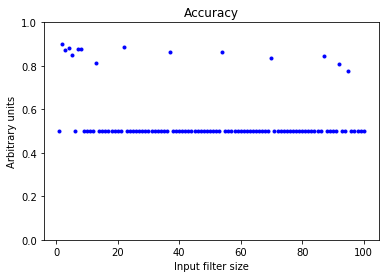

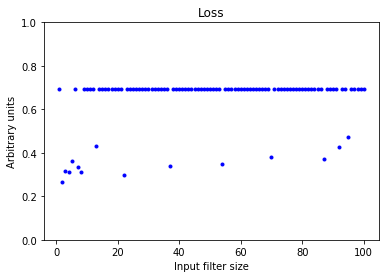

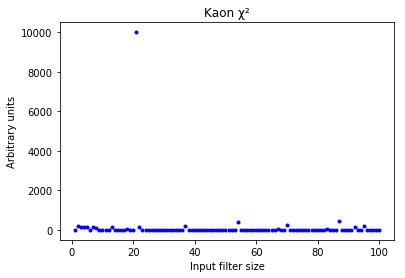

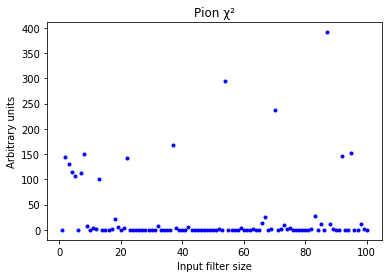

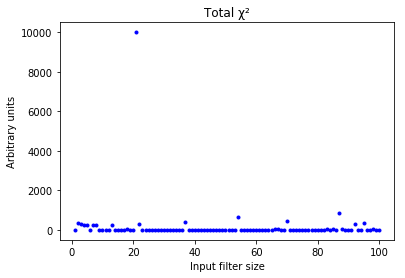

Converting plots to ROOT...


'################  Plot Purity and Chi2  ################\nprint("Plotting purity and χ²")\n\n# Plot accuracy\nf = plt.figure()\nplt.plot(metrics[0],metrics[1],\'b.\', scaley = False)\nplt.title("Accuracy")\nplt.xlabel("Filter size")\nplt.ylabel("Arbitrary units")\nplt.show()\nf.savefig("allFilters_acc.png")\n\n# Plot loss\nf = plt.figure()\nplt.plot(metrics[0],metrics[2],\'b.\', scaley = False)\nplt.title("Loss")\nplt.xlabel("Filter size")\nplt.ylabel("Arbitrary units")\nplt.show()\nf.savefig("allFilters_loss.png")\n\n# Plot kaon chi2\nf = plt.figure()\nplt.plot(metrics[0],metrics[3][0],\'b.\')\nplt.title("Kaon χ²")\nplt.xlabel("Filter size")\nplt.ylabel("Arbitrary units")\nplt.show()\nf.savefig("allFilters_chi2_kaon.png")\n\n# Plot pion chi2\nf = plt.figure()\nplt.plot(metrics[0],metrics[3][1],\'b.\')\nplt.title("Pion χ²")\nplt.xlabel("Filter size")\nplt.ylabel("Arbitrary units")\nplt.show()\nf.savefig("allFilters_chi2_pion.png")\n\n# Plot total chi2\nf = plt.figure()\nplt.plot(metri

In [0]:
################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("inputFilter_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("inputFilter_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("inputFilter_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("inputFilter_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("inputFilter_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("inputFilter_acc.png")
files.download("inputFilter_loss.png")
files.download("inputFilter_chi2_kaon.png")
files.download("inputFilter_chi2_pion.png")
files.download("inputFilter_chi2_tot.png")

files.download("inputFilter_acc.root")
files.download("inputFilter_loss.root")
files.download("inputFilter_chi2_kaon.root")
files.download("inputFilter_chi2_pion.root")
files.download("inputFilter_chi2_tot.root")


"""################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("allFilters_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("allFilters_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("allFilters_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("allFilters_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("allFilters_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("allFilters_acc.png")
files.download("allFilters_loss.png")
files.download("allFilters_chi2_kaon.png")
files.download("allFilters_chi2_pion.png")
files.download("allFilters_chi2_tot.png")

files.download("allFilters_acc.root")
files.download("allFilters_loss.root")
files.download("allFilters_chi2_kaon.root")
files.download("allFilters_chi2_pion.root")
files.download("allFilters_chi2_tot.root")


################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("inputLayer_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("inputLayer_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("inputLayer_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("inputLayer_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("inputLayer_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("inputLayer_acc.png")
files.download("inputLayer_loss.png")
files.download("inputLayer_chi2_kaon.png")
files.download("inputLayer_chi2_pion.png")
files.download("inputLayer_chi2_tot.png")

files.download("inputLayer_acc.root")
files.download("inputLayer_loss.root")
files.download("inputLayer_chi2_kaon.root")
files.download("inputLayer_chi2_pion.root")
files.download("inputLayer_chi2_tot.root")


################################################################################################




################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Layer sizes")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Layer sizes")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Layer sizes")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("allLayers_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("allLayers_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("allLayers_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("allLayers_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("allLayers_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("allLayers_acc.png")
files.download("allLayers_loss.png")
files.download("allLayers_chi2_kaon.png")
files.download("allLayers_chi2_pion.png")
files.download("allLayers_chi2_tot.png")

files.download("allLayers_acc.root")
files.download("allLayers_loss.root")
files.download("allLayers_chi2_kaon.root")
files.download("allLayers_chi2_pion.root")
files.download("allLayers_chi2_tot.root")
"""

In [0]:
import os
print( os.getcwd() )
#print( os.listdir() )

/content
['.config', 'inputLayer_acc.png', 'gdrive', 'inputLayer_loss.png', 'sample_data']


In [0]:
from google.colab import files
files.download("inputLayer_acc.png")


Filling histograms...


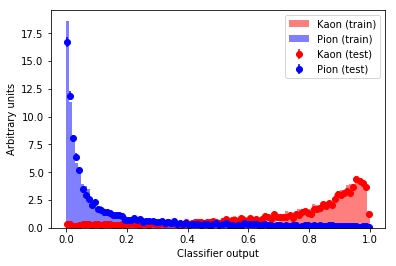

In [0]:
###################  Evaluation  #################

# Evaluate performance by comparing test and training classifier (model) response
decisions = []
for (X,y) in ((data_train_images, target_train_images), (data_test_images, target_test_images)):
    d1 = model.predict_proba(X[y>0.5])[:,1].ravel()
    d2 = model.predict_proba(X[y<0.5])[:,1].ravel()
    decisions += [d1, d2]
    
print("Filling histograms...")

bins = 100
low = min(np.min(d) for d in decisions)
high = max(np.max(d) for d in decisions)
low_high = (low,high)

plt.clf()
# Plot training decisions
plt.hist(decisions[0], color='r', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=True, label='Kaon (train)')
plt.hist(decisions[1], color='b', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=True, label='Pion (train)')

# make histogram and get error bars
hist, bins = np.histogram(decisions[2], bins=bins, range=low_high, density=True)
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

# plot histogram for signal test sample (Kaon Test)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale
plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Kaon (test)')

# make and plot histogram for background test sample (Pion Test)
hist, bins = np.histogram(decisions[3], bins=bins, range=low_high, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale
plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Pion (test)')

plt.xlabel("Classifier output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.show()